In [15]:
%config IPCompleter.greedy=True

In [16]:
import sys
import os
import pandas as pd
sys.path.append("../..") # relative path to module toolkit

In [17]:
#from keras.applications import ResNet50
#from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras_preprocessing.image import ImageDataGenerator
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# setup
batch_size = 1
val_dir = "../../../images/images_genus/test/"
val_images = 1644
datasetDir = "images_genus/"
saved_model = 'resNet50pretrained.h5'
results_file = "results_test.csv"
confusion_matrix_path = './confusion_matrix_norm_test.png'
classification_report_test = 'classification_report2_test.csv'

In [19]:
labels = getLabelsFromDir(val_dir)
val_datagen = ImageDataGenerator(rescale=1./255.)
validation_steps = int(val_images/batch_size) 

In [20]:
model = load_model(saved_model)

In [21]:
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=False,
                                                    seed=1)

Found 1644 images belonging to 44 classes.


In [22]:
Y_pred = model.predict_generator(val_generator, steps=validation_steps, verbose=1)

1644/1644 [==============================] - 44s 26ms/step


In [23]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred3 = [y[-3:] for y in np.argsort(Y_pred, axis=1)] 

In [24]:
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split(' ')
        row_data = [data for data in row_data if data]
        if len(row_data) > 0:
            row['class'] = row_data[0] + " " + row_data[1]
            row['precision'] = float(row_data[2])
            row['recall'] = float(row_data[3])
            row['f1_score'] = float(row_data[4])
            row['support'] = float(row_data[5])
            report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(classification_report_test, index = False)

In [26]:
report = classification_report(val_generator.classes, y_pred, target_names=labels)
#classification_report_csv(report)
print(report)

              precision    recall  f1-score   support

  Lobrathium       0.85      1.00      0.92        11
    Achenium       0.80      1.00      0.89         4
 Acylophorus       1.00      1.00      1.00        10
     Astenus       1.00      1.00      1.00        56
     Atrecus       0.86      1.00      0.92         6
     Bisnius       0.98      0.99      0.99       100
      Cafius       0.94      1.00      0.97        29
  Creophilus       1.00      1.00      1.00         4
Dinothenarus       1.00      0.75      0.86         4
        Emus       1.00      1.00      1.00         2
 Erichsonius       1.00      1.00      1.00        18
   Euryporus       1.00      0.75      0.86         4
     Gabrius       0.98      0.98      0.98        55
  Gabronthus       1.00      1.00      1.00         2
 Gauropterus       1.00      1.00      1.00         7
  Gyrohypnus       0.96      0.92      0.94        24
 Heterothops       1.00      1.00      1.00        29
  Lathrobium       1.00    

Normalized confusion matrix
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


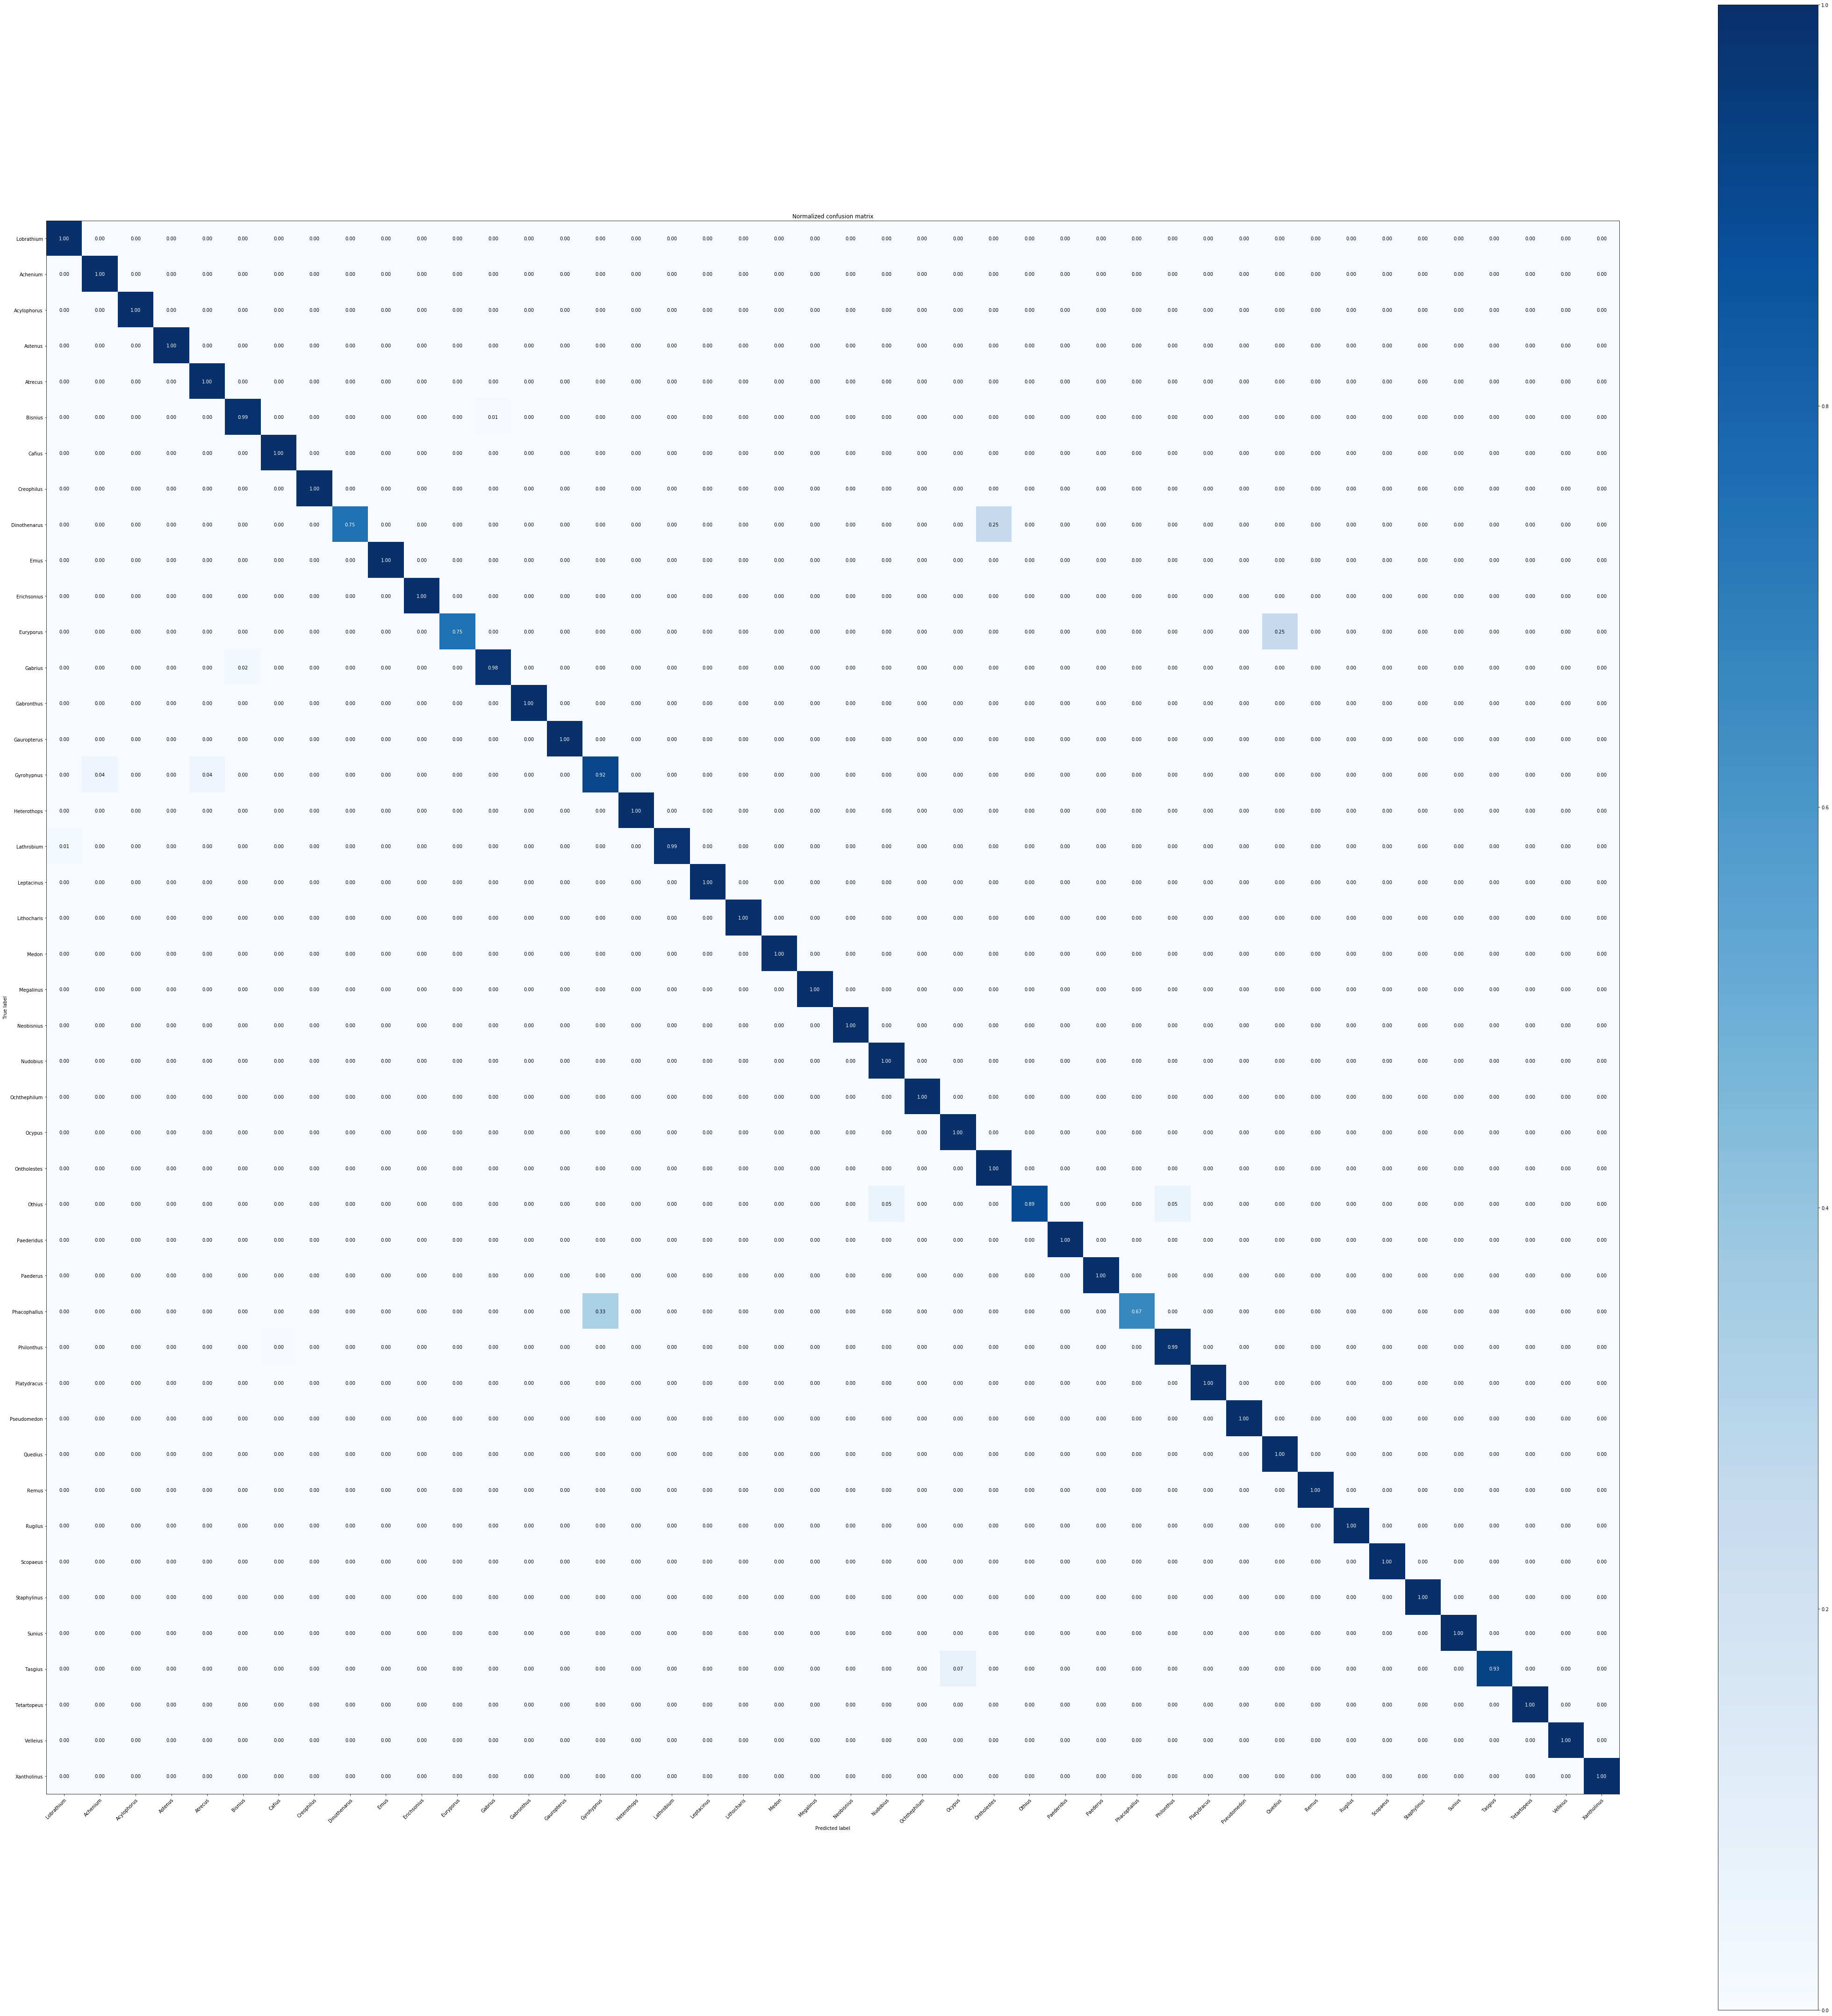

In [27]:
y_true = val_generator.classes
matplotlib.rcParams['figure.figsize'] = [60, 60]
fig, ax = plot_confusion_matrix(y_true, y_pred, np.array(labels), normalize=True)
fig.savefig(confusion_matrix_path)

In [28]:
labels = (val_generator.class_indices) # dict of label:index
labels = dict((i,l) for l,i in labels.items()) # dict of index:label

In [29]:
# create pd.dataframe and save predictions to .csv
filenames=[datasetDir + name for name in val_generator.filenames]
y_pred_labels = [labels[y] for y in y_pred]
y_true_labels = [labels[y] for y in y_true]
y_pred3_labels = []
for i,top3 in enumerate(y_pred3):
    l = []
    for top in top3:
        l.append((labels[top], Y_pred[i][top]))
    y_pred3_labels.append(l)

results=pd.DataFrame({"Filename":filenames,
                      "Label":y_true_labels,
                      "Prediction1":y_pred_labels,
                      "Prediction3":y_pred3_labels})
results.to_csv(results_file,index=True)